In [1]:
import sys
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    return mask_image
    # ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def get_predictor():
    sam_checkpoint = "/data/machine/nerfstudio/segment-anything/sam_vit_h_4b8939.pth"
    model_type = "vit_h"
    device = "cuda"
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    predictor = SamPredictor(sam)
    return predictor

predictor = get_predictor()

0.08799123764038086
0.02183079719543457
0.14579319953918457
0.004667043685913086


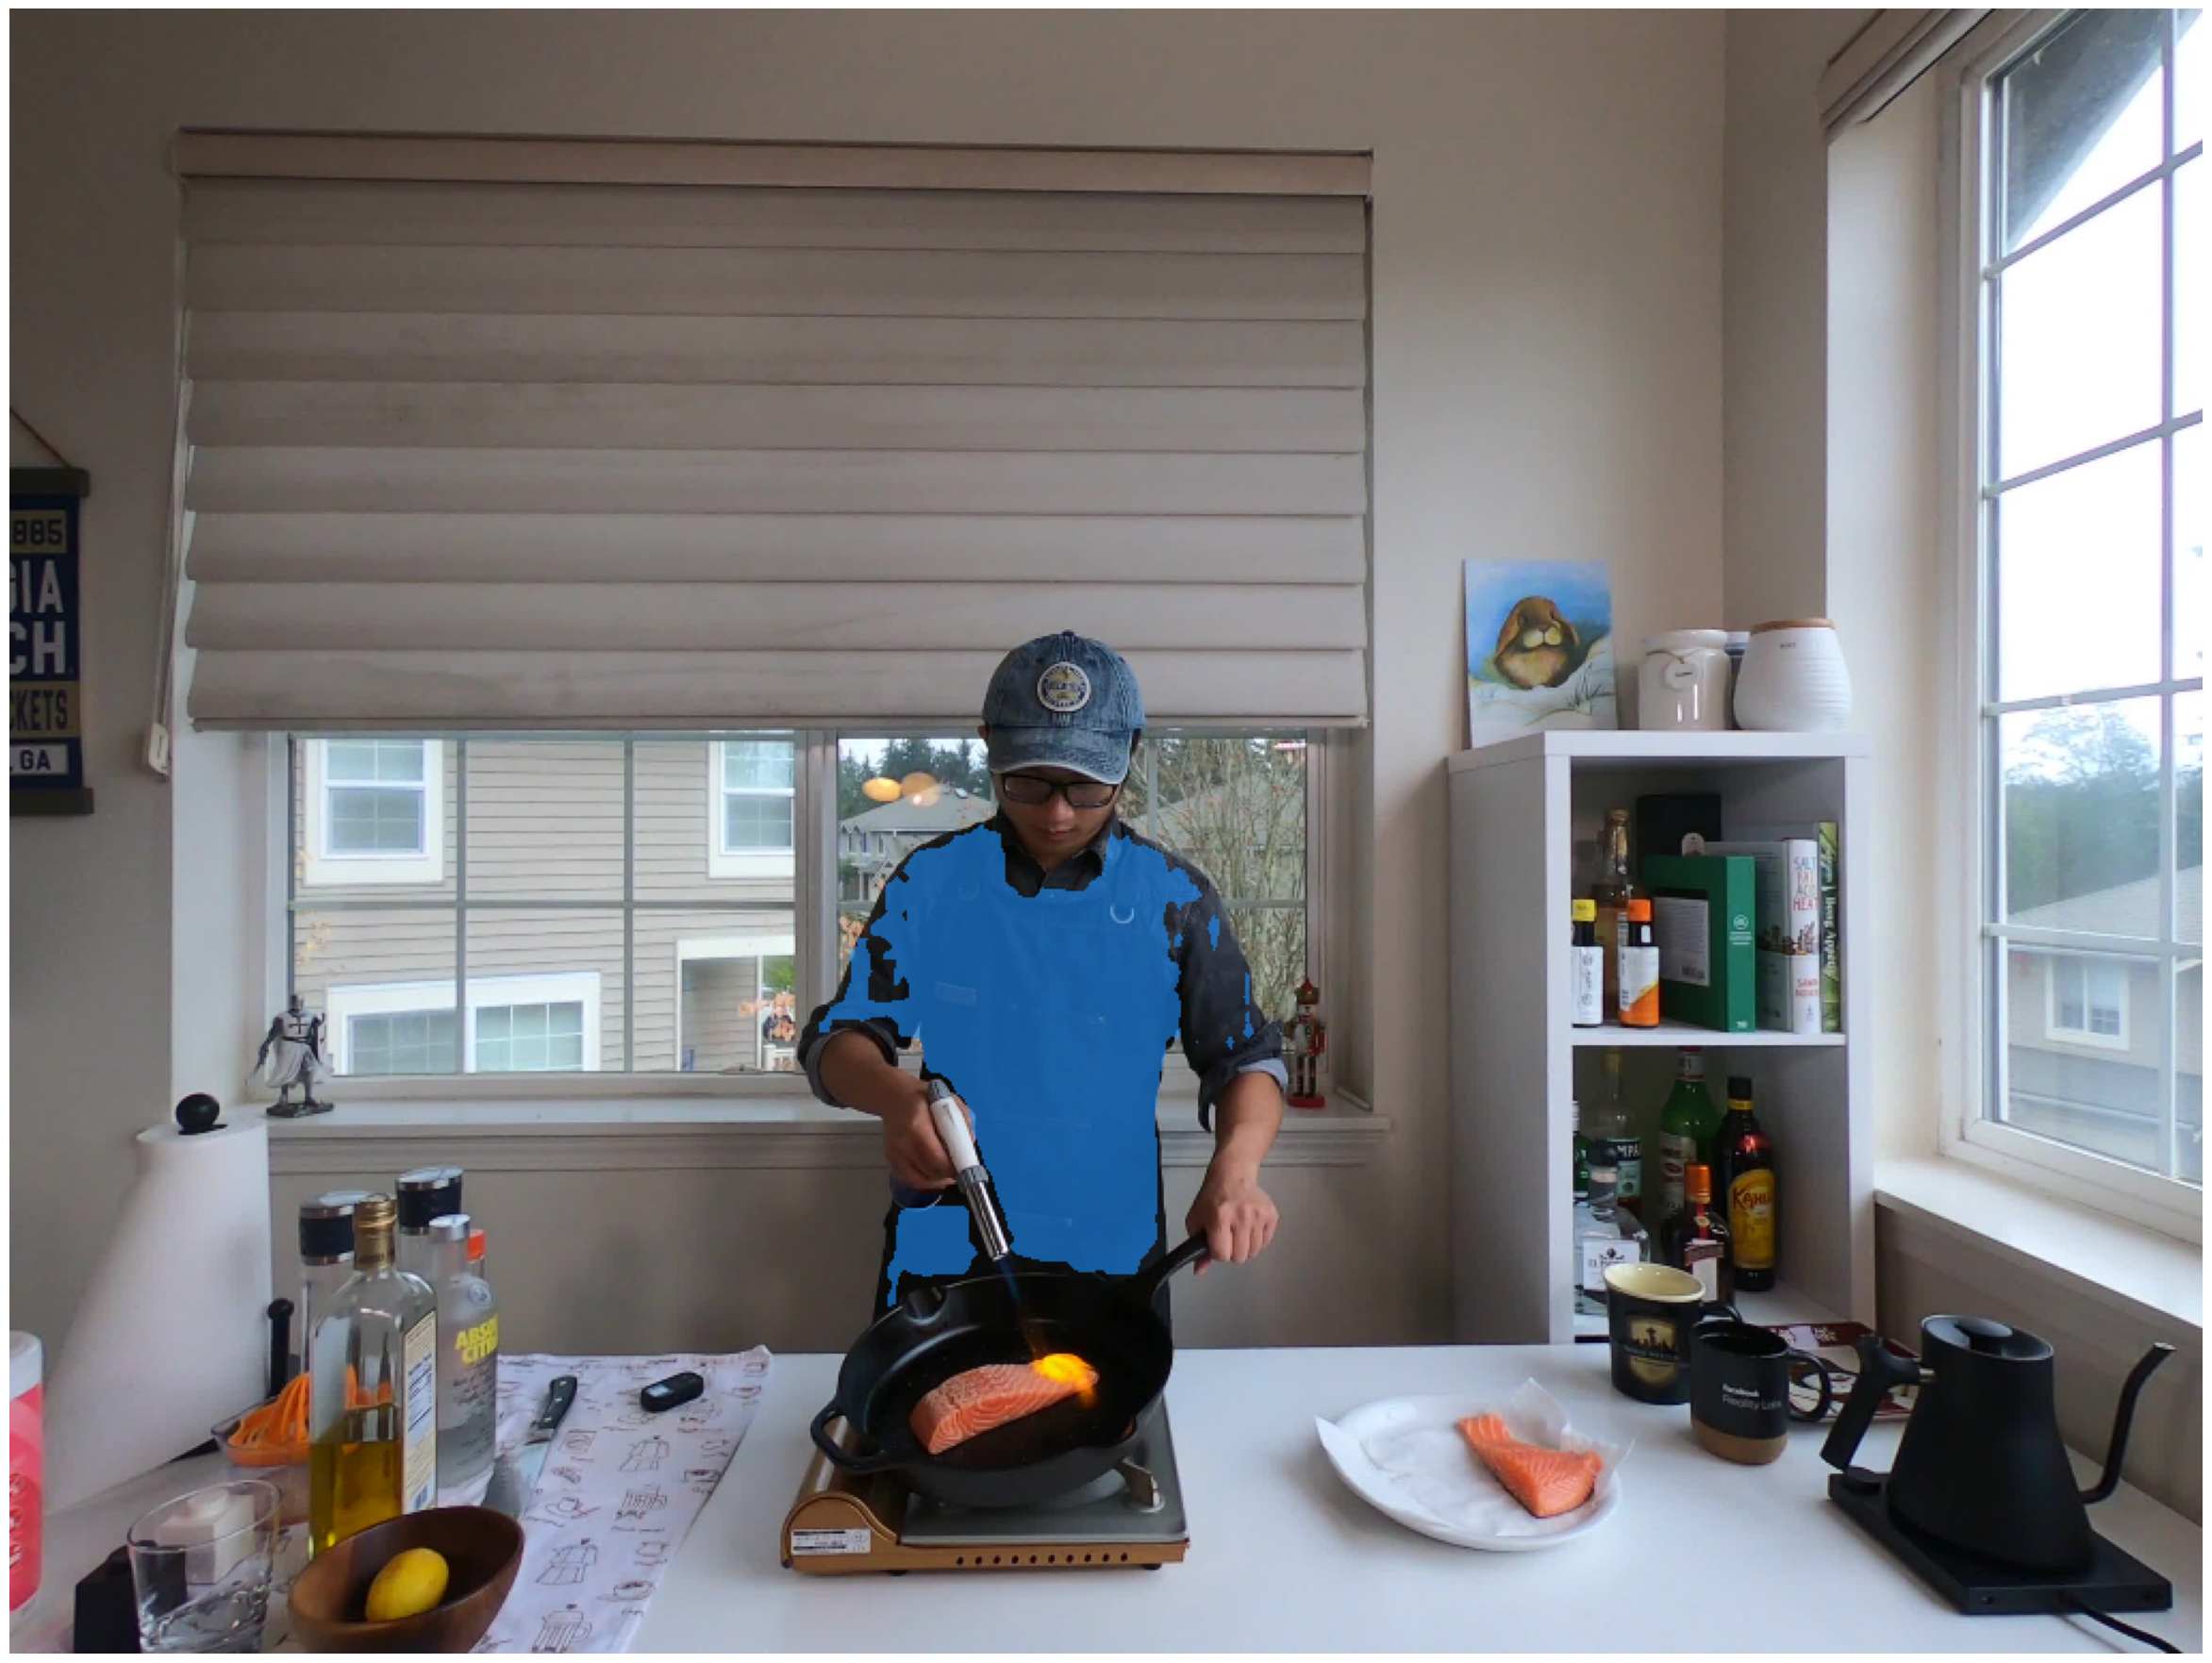

In [6]:
import time
_t0 = time.time()
image = cv2.imread('/data/machine/data/flame_salmon_image/images/cam00_0001.jpg')
image = cv2.resize(image, (1024, 768))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
feature = np.load('/data/machine/nerfstudio/res.npy').transpose(2, 0, 1)
predictor.set_feature(feature, image.shape[:2])
print(time.time() - _t0)

_t1 = time.time()
input_point = np.array([[500, 475]])
input_label = np.array([1])
# plt.figure(figsize=(10,10))
# plt.imshow(image)
# #show_points(input_point, input_label, plt.gca())
# plt.axis('on')
# plt.show()
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)
# image = np.concatenate([image, np.ones((image.shape[0], image.shape[1], 1))], axis=-1)
def get_masked_image(mask, image):
    mask_img = show_mask(mask, plt.gca())
    mask_img[..., :3] = mask_img[..., :3] * 255
    mask_p_img = mask_img[...,:3]*mask_img[...,3:] + image*(1-mask_img[...,3:])
    mask_p_img = mask_p_img.astype(np.uint8)
    return mask_p_img

plt.figure(figsize=(30,60))
imgs = []
allscores = []
# for i, (mask, score) in enumerate(zip(masks, scores)):
#     mask_img = get_masked_image(mask, image)
#     cv2.circle(img=mask_img, center=tuple(input_point[0]), radius=1, color=(255,255,0), thickness=5)
#     imgs.append(mask_img)
#     allscores.append(score)
print(time.time() - _t1)
_t2 = time.time()
mask_img = get_masked_image(masks[0], image)
print(time.time() - _t2)
_t3 = time.time()
plt.axis("off")
plt.imshow(mask_img)
print(time.time() - _t3)
# plt.imshow(np.concatenate(imgs, axis=1))
# plt.imshow(imgs[-1])
# print(allscores)

In [3]:
# import numpy as np
# feature_gt = np.load('/data/machine/data/flame_salmon_image/sam_features/eval/cam00_0001.npy')
# predictor.set_feature(feature_gt, image.shape[:2])

# input_point = np.array([[500, 375]])
# input_label = np.array([1])
# plt.figure(figsize=(10,10))
# plt.imshow(image)
# show_points(input_point, input_label, plt.gca())
# plt.axis('on')
# plt.show()

# masks, scores, logits = predictor.predict(
#     point_coords=input_point,
#     point_labels=input_label,
#     multimask_output=True,
# )
# for i, (mask, score) in enumerate(zip(masks, scores)):
#     plt.figure(figsize=(10,10))
#     plt.imshow(image)
#     show_mask(mask, plt.gca())
#     show_points(input_point, input_label, plt.gca())
#     plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
#     plt.axis('off')
#     plt.show()  